# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 7. Решающие деревья и случайные леса.


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds23_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. Дождитесь подтверждения от бота, что он принял файл. Если подтверждения нет, то что-то не так. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**. Если вы строите интерактивные графики, их стоит прислать в формате html.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* **Код из рассказанных на занятиях ноутбуков** можно использовать без ограничений.




**Баллы за задание:**

* Задача 1 &mdash; 15 баллов
* Задача 2 &mdash; 50 баллов
* Задача 3 &mdash; 30 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [1]:
# Bot check

# HW_ID: fpmi_ad7
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', font_scale=1.3, palette='Set2')

При решении задания используйте `sklearn`. Пропишите сюда необходимые импорты

In [3]:
from sklearn import datasets
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split

import graphviz
import warnings
warnings.filterwarnings("ignore")

Перед выполнением задания обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/trees.html">ноутбук</a> с занятия по решающим деревьям.

---
### Задача 1.

Перед обучением линейной регрессии вы могли совершать некоторые преобразования над признаками. Какие преобразования стоит совершить перед обучением решающего дерева?

В частности, ответьте на вопрос, имеет ли смысл примененять следующие преобразования:
* монотонные функции от одного признака;
* немонотонные функции от одного признака;
* линейные функции от нескольких признаков;
* нелинейные функции от нескольких признаков;
* стандартизация признаков;
* преобразования категориальных признаков.

Например, вместо/дополнительно признака $x_j$ рассматривать признак $f(x_j)$, для указанных выше типов функций.

Поскольку задача решающего дерева --- разбивать вершины на группы и давать предсказания по выборочному среднему значению целевого признака, то было бы хорошо иметь явно выраженные объединения объектов в группы.

 Если мы возьмём функцию от признака, то не получим новые отдельные группы объектов, поэтому брать любые функции от одного признака нет смысла.

Думаю, есть смысл добавлять признаки, полученные путём какого-либо комбинирования имеющихся, поскольку в таком случае могут образоваться более явные группы похожих объектов, и решающее дерево точнее будет разделять выборки по этому новому признаку.

Стандартизация признаков точно не имеет смысла, поскольку в решающем дереве мы работаем с конкретным признаком и ставим условия разбиения по нему в отличие от модели линейной регрессии, где, чтобы сделать оценку, необходимо выполнить операции с матрицами и важно, в каких единицах измерения представлены значения.

Решающие деревья могут неплохо работать с категориальными признаками. Если признак $x_{j}$ принимает значения из множества $C = \{c_{1},...,c_{m}\}$, то при очередном разбиении мы можем рассматривать по этому признаку произвольные сплиты вида $C = C_{l} \cup C_{r}$. проблема в том, что при больших $M$ у нас будет $2^{M - 1} - 1$ сплитов, и перебирать их будет слишком долго. Поэтому, для задачи бинарной классификации значения $c_{m}$ можно упорядочить по неубыванию доли объектов класса с $x_{j} = c_{m}$, после чего работать с ними, как со значениями вещественного признака. Для задачи регрессии с функцией потерь MSE значения $c_{m}$ можно упорядочивать по среднему значению таргета на подмножестве $\{X | x_{j} = c_{m}$. Полученный таким образом сплит тоже будет оптимальным.

Помимо рассмотренных возможностей, следует обрабатывать выбросы, поскольку наша модель не должна их предсказывать.

Насчёт пропусков:
Если мы делаем сплит по признаку, который пропущен в некотором подмножестве $V_{m}$ нашей исходной выборки, то мы игнорируем $V_{m}$, а когда сплит выбран, закидываем $V_{m}$ как в left, так и в right. Теперь рассмотрим этап применения дерева. Допустим, в вершину, где сплит идёт по i-му признаку, пришёл объект $x_{0}$ с пропущенным значением этого признака. Предлагается отправить его в каждую из дальнейших веток и получить по ним предсказания $\hat{y_{l}}$ и $\hat{y_{r}}$. Эти предсказания мы усредним.
Если речь идёт о категориальном признаке, может оказаться хорошей идеей ввести дополнительное значение «пропущено» для категориального признака и дальше работать с пропусками, как с обычным значением. Особенно это актуально в ситуациях, когда пропуски имеют системный характер и их наличие несёт в себе определённую информацию.


---
### Задача 2.

Рассмотрим данные из <a href="https://miptstats.github.io/courses/ad_fivt/task6.html" target="_blank">предыдущего домашнего задания</a>. Скачайте данные и разделите их на три части &mdash; обучающую, валидационную и тестовую в соотношении 3:1:1.

Считаем данные и выберем только необходимые признаки (избавимся от линейной зависимости в признаках и уберём те, которые не влияют на целевой столбец), а также переименуем столбец "season":

In [4]:
data = pd.read_csv("day.csv")
data = data[['season', 'mnth', 'holiday', 'workingday', 'weekday', 'weathersit', 'temp', 'hum', 'windspeed', 'cnt']]
data['season'] = data['season'].map({1 : 'winter', 2 : 'spring', 3 : 'summer', 4 : 'autumn'})
data.head()

,season,mnth,holiday,workingday,weekday,weathersit,temp,hum,windspeed,cnt
0,winter,1,0,0,6,2,0.344167,0.805833,0.160446,985
1,winter,1,0,0,0,2,0.363478,0.696087,0.248539,801
2,winter,1,0,1,1,1,0.196364,0.437273,0.248309,1349
3,winter,1,0,1,2,1,0.200000,0.590435,0.160296,1562
4,winter,1,0,1,3,1,0.226957,0.436957,0.186900,1600


In [44]:
data.loc[0, 'temp']

0.344167

Разделим на обучающую, валидационную и тестовую выборки в соотношении 3:1:1:

In [5]:
train, tmp = train_test_split(data, test_size=0.4, shuffle=True)
valid, test = train_test_split(tmp, test_size=0.5, shuffle=True)

In [6]:
train.shape, valid.shape, test.shape

((438, 10), (146, 10), (147, 10))

Выполните необходимые преобразования признаков.

*Замечание.* Если в валидационной и/или тестовой частях есть "большие" выбросы, их стоит убрать. Наша модель не должна пытаться их предсказать, но в то же время выбросы вносят существенный вклад в значение метрики.

Пропусков нет, и они и так обрабатываются в решающем дереве.

In [7]:
data.isnull().any().any()

False

Исследуем данные на выбросы с помощью boxplot-диаграммы:

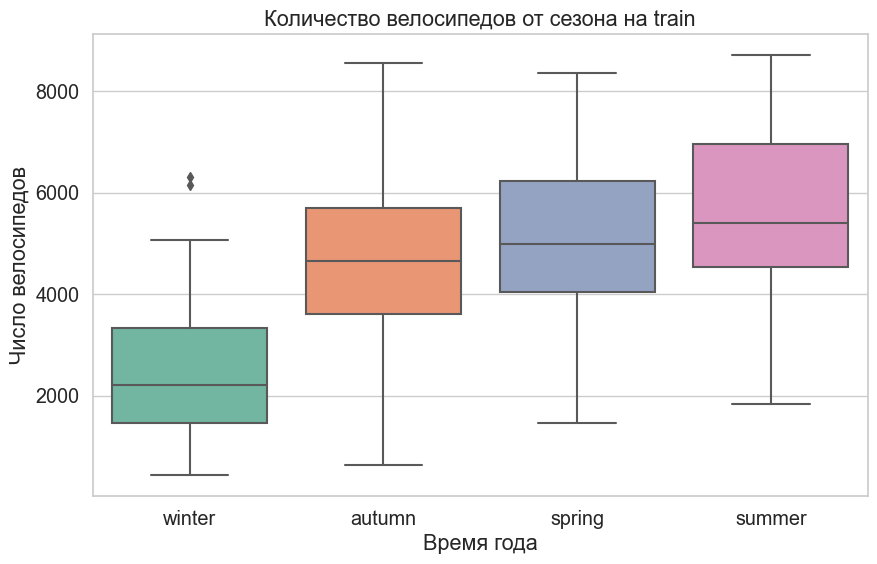

In [8]:
plt.figure(figsize=(10, 6))

sns.boxplot(train, x=train['season'], y=train['cnt'])

plt.title("Количество велосипедов от сезона на train")
plt.xlabel("Время года")
plt.ylabel("Число велосипедов")

plt.show()

Уберём выбросы для зимы и осени:

In [9]:
train = train[(train['season'] == 'spring') | (train['season'] == 'summer') |
              (train['season'] == 'autumn') | ((train['season'] == 'winter') & (train['cnt'] < 5500))]
train = train[(train['season'] == 'winter') | (train['season'] == 'spring') |
              (train['season'] == 'summer') | ((train['season'] == 'autumn') & (train['cnt'] > 100) & (train['cnt'] < 8000))]

Теперь посмотрим на valid выборку:

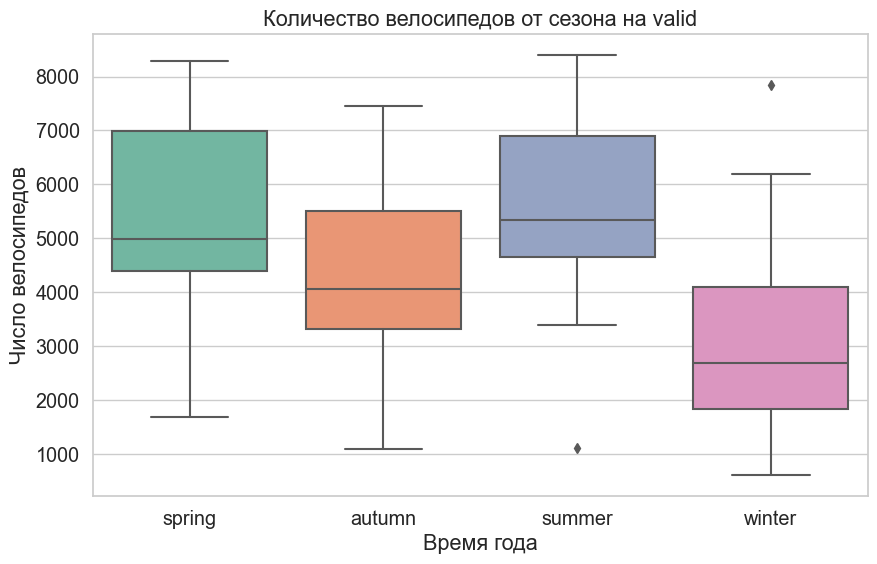

In [10]:
plt.figure(figsize=(10, 6))

sns.boxplot(valid, x=valid['season'], y=valid['cnt'])

plt.title("Количество велосипедов от сезона на valid")
plt.xlabel("Время года")
plt.ylabel("Число велосипедов")

plt.show()

In [11]:
valid = valid[(valid['season'] == 'spring') | (valid['season'] == 'summer') |
              (valid['season'] == 'autumn') | ((valid['season'] == 'winter') & (valid['cnt'] < 5500))]
valid = valid[(valid['season'] == 'winter') | (valid['season'] == 'spring') |
              (valid['season'] == 'summer') | ((valid['season'] == 'autumn') & (valid['cnt'] > 100))]

И на тестовую:

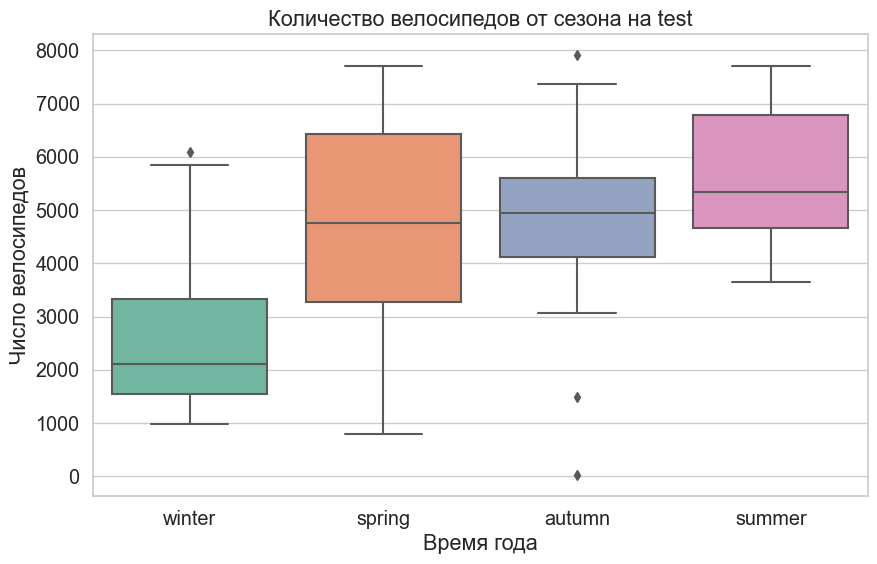

In [12]:
plt.figure(figsize=(10, 6))

sns.boxplot(test, x=test['season'], y=test['cnt'])

plt.title("Количество велосипедов от сезона на test")
plt.xlabel("Время года")
plt.ylabel("Число велосипедов")

plt.show()

In [13]:
test = test[(test['season'] == 'winter') | (test['season'] == 'spring') |
              (test['season'] == 'summer') | ((test['season'] == 'autumn') & (test['cnt'] > 0))]
test = test[((test['season'] == 'winter') & (test['cnt'] < 5500)) | (test['season'] == 'spring') |
            (test['season'] == 'summer') | (test['season'] == 'autumn')]

Обработаем категориальные признаки, применив OneHotEncoding:

In [14]:
# Разделим столбцы по их типу
cat_features = ['season', 'mnth', 'weekday', 'workingday', 'weathersit']
real_features = ['temp', 'hum', 'windspeed']
target_feature = 'cnt'

In [15]:
# Создадим кодировщик и применим к категориальным train-столбцам
encoder = OneHotEncoder(drop='first', sparse=False)
train_cat = encoder.fit_transform(train[cat_features])

# Построим столбцы с читабельными названиями
convert_cols = np.hstack([real_features, encoder.get_feature_names_out(cat_features)])

X_train = pd.DataFrame(np.hstack([train[real_features], train_cat]), columns=convert_cols)

convert_cols

array(['temp', 'hum', 'windspeed', 'season_spring', 'season_summer',
       'season_winter', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6',
       'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'workingday_1', 'weathersit_2', 'weathersit_3'],
      dtype=object)

Аналогичную работу проделаем с valid и test:

In [16]:
valid_cat = encoder.transform(valid[cat_features])
X_valid = pd.DataFrame(np.hstack([valid[real_features], valid_cat]), columns=convert_cols)

In [17]:
test_cat = encoder.transform(test[cat_features])
X_test = pd.DataFrame(np.hstack([test[real_features], test_cat]), columns=convert_cols)

Обучите решающее дерево глубины 3 и визуализируйте его. 

*Рекомендуется сохранить визуализацию в html и отправить ее вместе с решением.*

In [18]:
# Объявляем модель
clf = DecisionTreeRegressor(max_depth=3, random_state=42)

Для визуализации напишем следующую функцию:

In [19]:
def get_graphviz_graph(model):
    '''
    Функция для обучения решающего дерева и построения
    по нему графа graphviz для визуализации
    '''

    model.fit(X_train, train[target_feature])
    dot_data = export_graphviz(
        model, out_file=None,
        feature_names=convert_cols, class_names='Price',
        filled=True, rounded=True, special_characters=True
    )
    return graphviz.Source(dot_data)

Получим объект для визуализации:

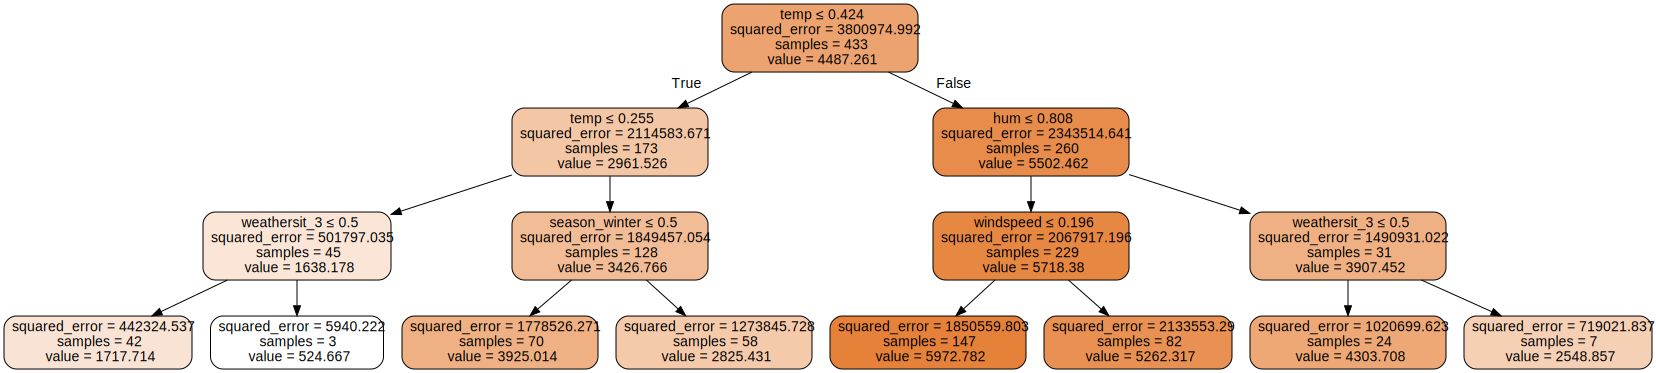

In [20]:
graph = get_graphviz_graph(clf)
graph

Сохраняю в формате png на устройстве и затем конвертирую в html в браузере.

In [21]:
graph.render("begin_graph_depth3", format='png');

Подберите оптимальное значение максимальной глубины дерева. Для этого обучите решающие деревья с выставленным значением соответствующего гиперпараметра и посчитайте ошибку предсказаний каждого из них на валидационной выборке. Постройте соответствующий график.

In [22]:
# Сетка значений max_depth
grid = [2, 3, 4, 5, 8, 11, 15, 19, 24, 29, 40, 50]

models = []

# Объявляем все модели
for depth in grid:
    models.append(DecisionTreeRegressor(random_state=42, max_depth=depth))

In [23]:
# Список ошибок для каждой модели
rmse_valid = []

# Процесс обучения, предсказания и подсчёта ошибки соответственно
for model in models:
    model.fit(X_train, train[target_feature])
    preds = model.predict(X_valid)

    rmse_valid.append(np.sqrt(((valid[target_feature] - preds) ** 2).mean()))

Визуализируем ошибку MSE на графике в зависимости от значения гиперпараметра:

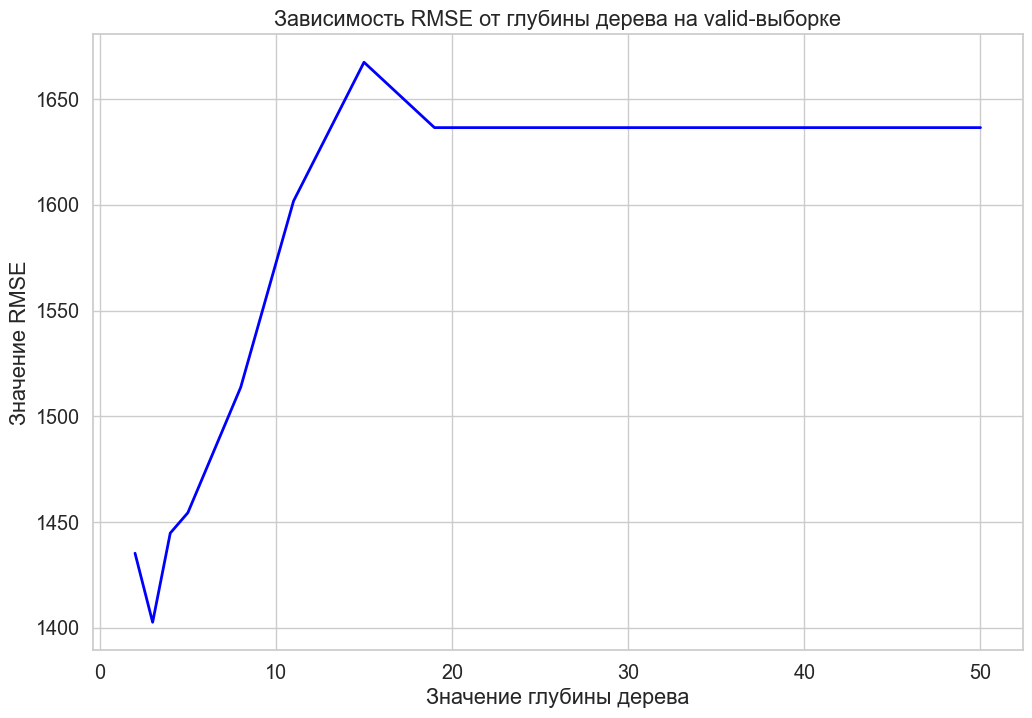

In [24]:
plt.figure(figsize=(12, 8))

plt.plot(grid, rmse_valid, color='blue', lw=2)
plt.title("Зависимость RMSE от глубины дерева на valid-выборке")
plt.xlabel("Значение глубины дерева")
plt.ylabel("Значение RMSE")

plt.show()

Найдём лучшее значение глубины дерева:

In [25]:
min_val = 1000000
pos = -1

for error in rmse_valid:
    if error < min_val:
        min_val = error
        pos += 1

best_depth = grid[pos]
best_depth

3

Аналогичным образом подберите минимальное число объектов в листе, зафиксировав при этом подобранное значение максимальной глубины.

In [26]:
# Сетка значений для max_lead_nodes
grid = [2, 3, 4, 5, 6, 15, 19, 24, 29, 40, 50, 60, 70, 80, 90, 100, 110, 130, 150, 170]

models = []

# Объявление моделей
for leaf in grid:
    models.append(DecisionTreeRegressor(random_state=42, max_depth=best_depth, max_leaf_nodes=leaf))

In [27]:
rmse_valid_leaf = []

# Процесс обучения, предсказания и подсчёта ошибки соответственно
for model in models:
    model.fit(X_train, train[target_feature])
    preds = model.predict(X_valid)

    rmse_valid_leaf.append(np.sqrt(((valid[target_feature] - preds) ** 2).mean()))

Визуализируем зависимость:

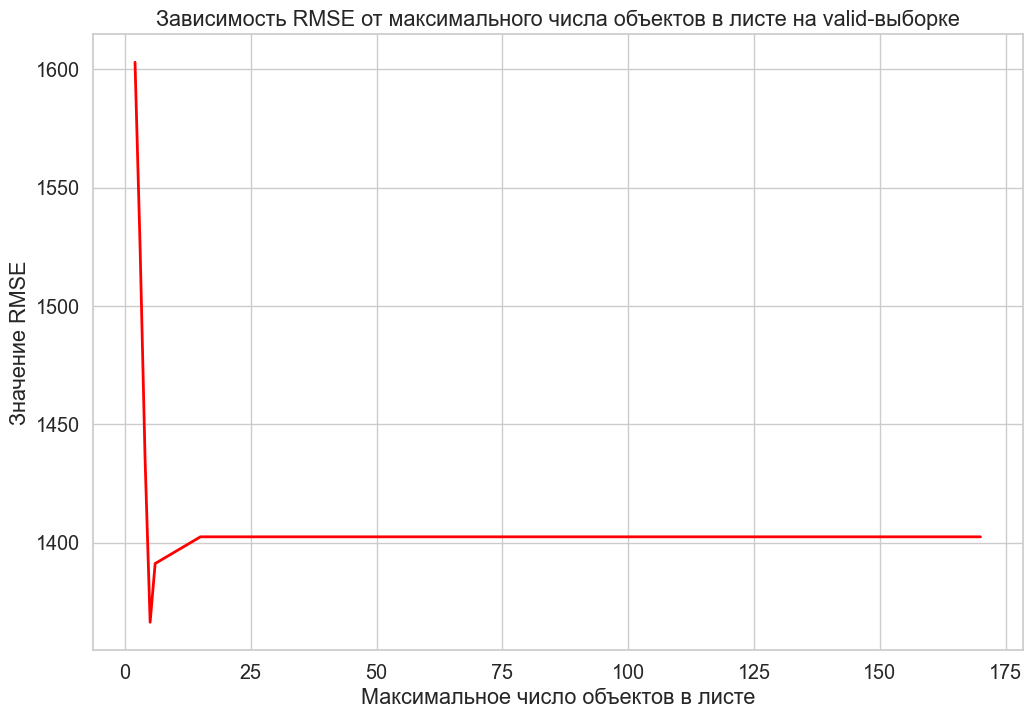

In [28]:
plt.figure(figsize=(12, 8))

plt.plot(grid, rmse_valid_leaf, color='red', lw=2)
plt.title("Зависимость RMSE от максимального числа объектов в листе на valid-выборке")
plt.xlabel("Максимальное число объектов в листе")
plt.ylabel("Значение RMSE")

plt.show()

Найдём лучшее значение:

In [29]:
min_val = 1000000
pos = -1

for error in rmse_valid_leaf:
    if error < min_val:
        min_val = error
        pos += 1

best_leaf = grid[pos]
best_leaf

5

Визуализируйте дерево при оптимальных гиперпараметрах и посчитайте его ошибку на тестовой части выборки.

In [30]:
# Объявляем модель
best_model = DecisionTreeRegressor(random_state=42, max_depth=best_depth, max_leaf_nodes=best_leaf)

Получаю визуализацию дерева, сохраняю в png и конвертирую затем в html (на сайте в браузере):

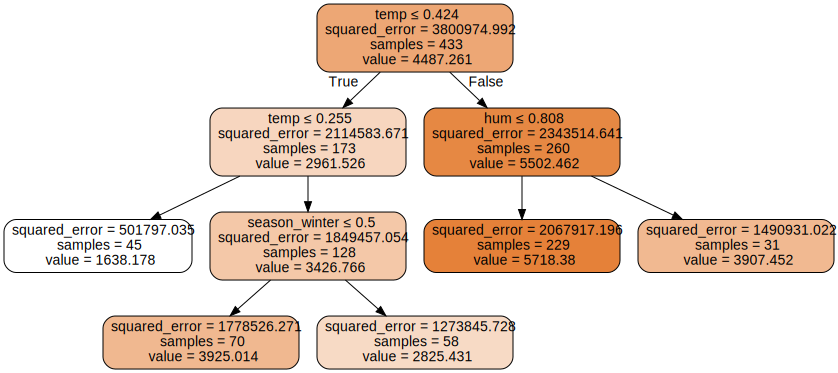

In [31]:
graph = get_graphviz_graph(best_model)
graph

In [32]:
graph.render("best_model", format="png");

Посчитаем ошибку RMSE на тестовой выборке:

In [33]:
test_preds = best_model.predict(X_test)
print("RMSE: ", np.sqrt(((test[target_feature] - test_preds) ** 2).mean()))

RMSE:  1364.1230894002235


Решающее дерево позволяет оценить *важность признаков* &mdash; некоторая величина, зависящая от того
* насколько часто тот или иной признак использовался при разбиении листа, 
* и насколько сильно при этом изменился критерий информативности.

У обученной модели значения важности признаков лежат в поле `feature_importances_`. Визуализируйте их с помощью `seaborn.barplot`.

In [34]:
# Получаем значения важности признаков
importance = pd.DataFrame(best_model.feature_importances_, index=convert_cols).T
importance

,temp,hum,windspeed,season_spring,season_summer,season_winter,mnth_2,mnth_3,mnth_4,mnth_5,...,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1,weathersit_2,weathersit_3
0,0.858696,0.098932,0.0,0.0,0.0,0.042372,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Удалим признаки, которые имеют нулевую важность:

In [35]:
for col in importance.columns:
    series = (importance[col] == 0)
    if series[0]:
        importance.drop([col], axis=1, inplace=True)

Визуализируем данные при помощи barplot:

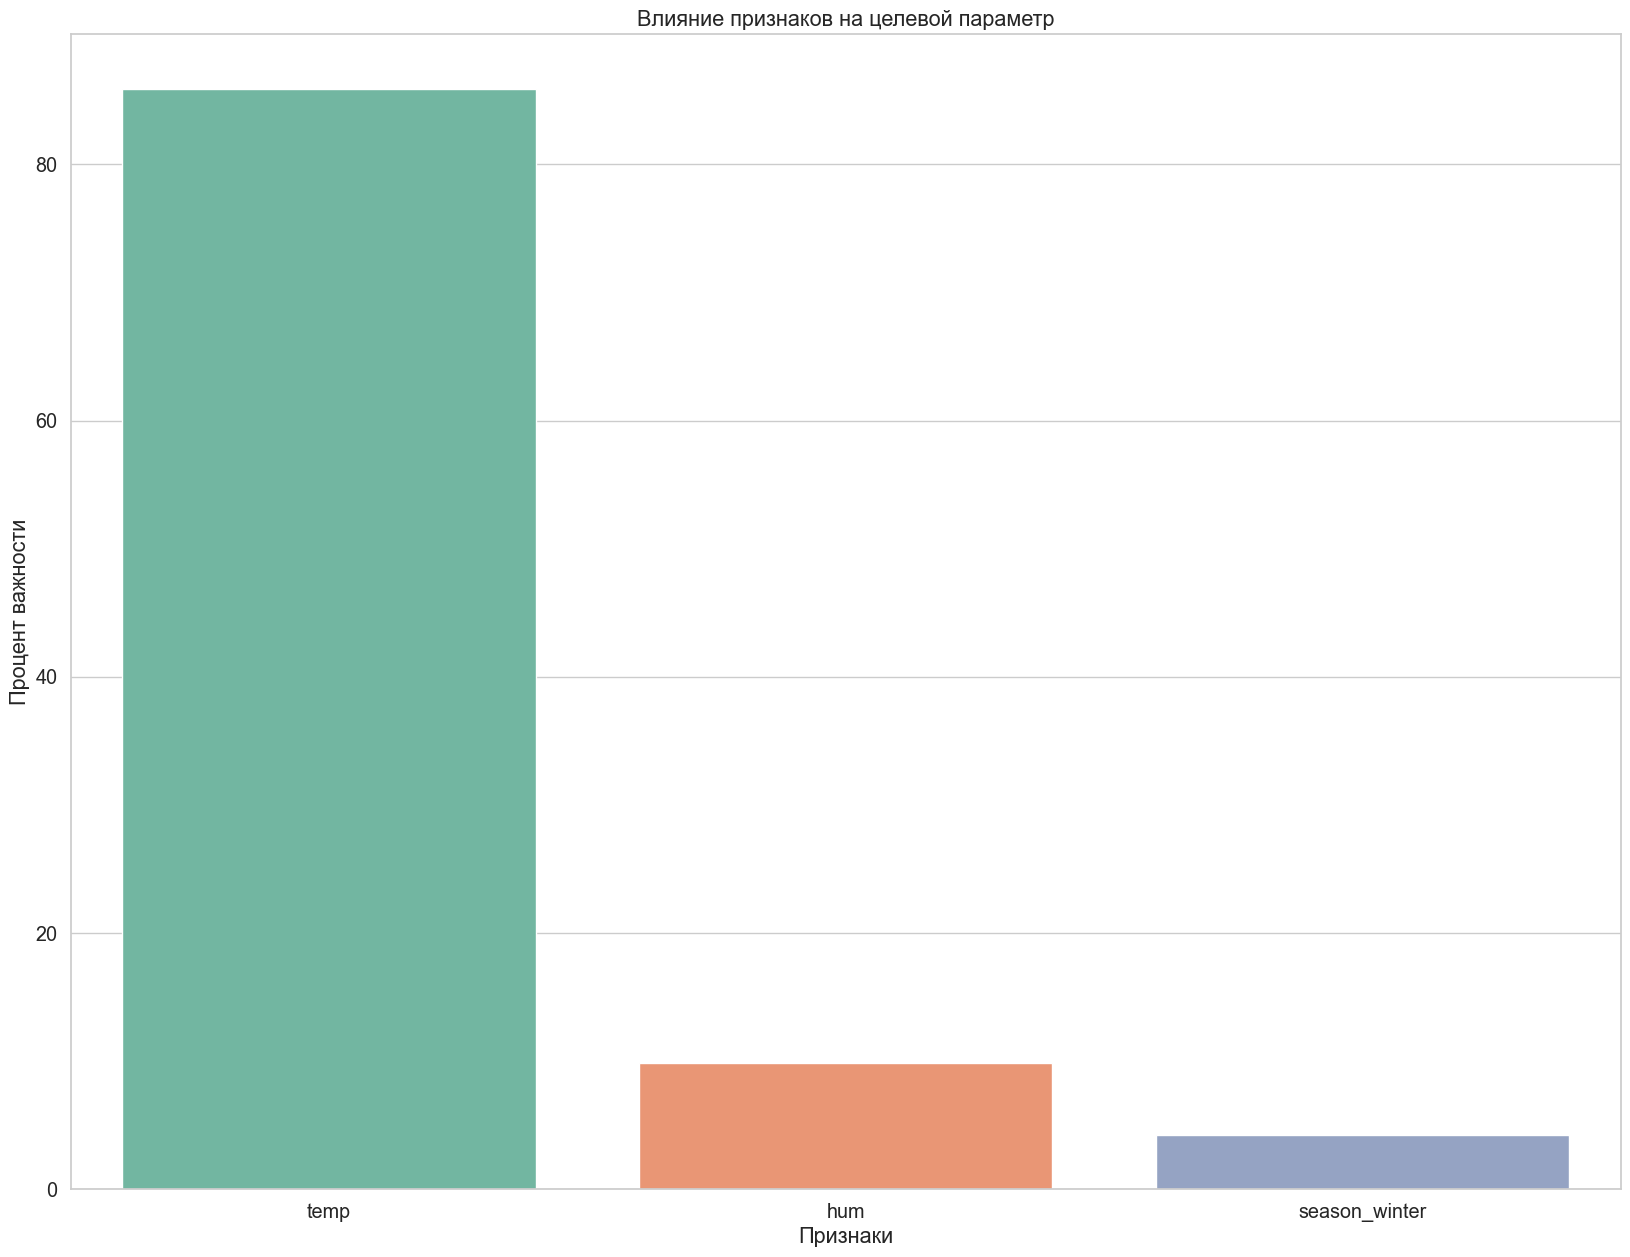

In [36]:
plt.figure(figsize=(20, 15))

sns.barplot(data=importance * 100)

plt.title("Влияние признаков на целевой параметр")
plt.xlabel("Признаки")
plt.ylabel("Процент важности")

plt.show()

Сделайте выводы.

Еще раз взглянули на датасет о количестве арендованных велосипедов за день, но теперь уже исследования предсказания проводились на основе модели машинного обучения "Решающее дерево". Была исследована зависимость ошибки от гиперпараметров: max_depth и max_lead_nodes. После определенного значения увеличение глубины дерева значение ошибки начинает увеличиваться. С числом объектов в листе дела обстоят другим образом: при их увеличении ошибка уменьшается вплоть до определенного значения (на этом пути возможны колебания графика). Смотря на визуализацию важных признаков, можно сделать вывод, что определяющим фактором аренды велосипеда является температура на улице, но и другие признаки, например, влажность и сезон года также влияют на решение, отправиться в поездку или нет (зимой, скорее всего, ездят мало). Модель показывает схожее качество в сравнении с моделью линейной регрессии: ошибка составляет около трети от среднего значения по целевому признаку.

---
### Задача 3.

Для данных из предыдущей части обучите случайный лес на 500 деревьев.

In [37]:
n_estimators = 500
forest_model = RandomForestRegressor(random_state=42, n_estimators=n_estimators)
forest_model.fit(X_train, train[target_feature]);

Постройте график зависимости ошибки модели в зависимости от количества деревьев для обучающей и валидационной выборок.

*Замечание.* Не нужно заново обучать лес каждый раз. Используйте у *обученной* модели поле `estimators_`, это список из объектов класса `DecisionTreeRegressor`. Обратите внимание, что это приватное поле объекта, и менять его очень плохо, за такое баллы будут снижаться.

In [38]:
# Суммируем все предсказания
sum_train = np.zeros(shape=X_train['windspeed'].shape)
sum_valid = np.zeros(shape=X_valid['windspeed'].shape)
count = 1

rmse_train = []
rmse_valid = []

for part in forest_model.estimators_:
    sum_train += part.predict(X_train)
    sum_valid += part.predict(X_valid)

    # Считаем ошибки, вычисляя среднее
    rmse_train.append(np.sqrt(((train[target_feature] - sum_train / count) ** 2).mean()))
    rmse_valid.append(np.sqrt(((valid[target_feature] - sum_valid / count) ** 2).mean()))

    count += 1

Визуализируем данные:

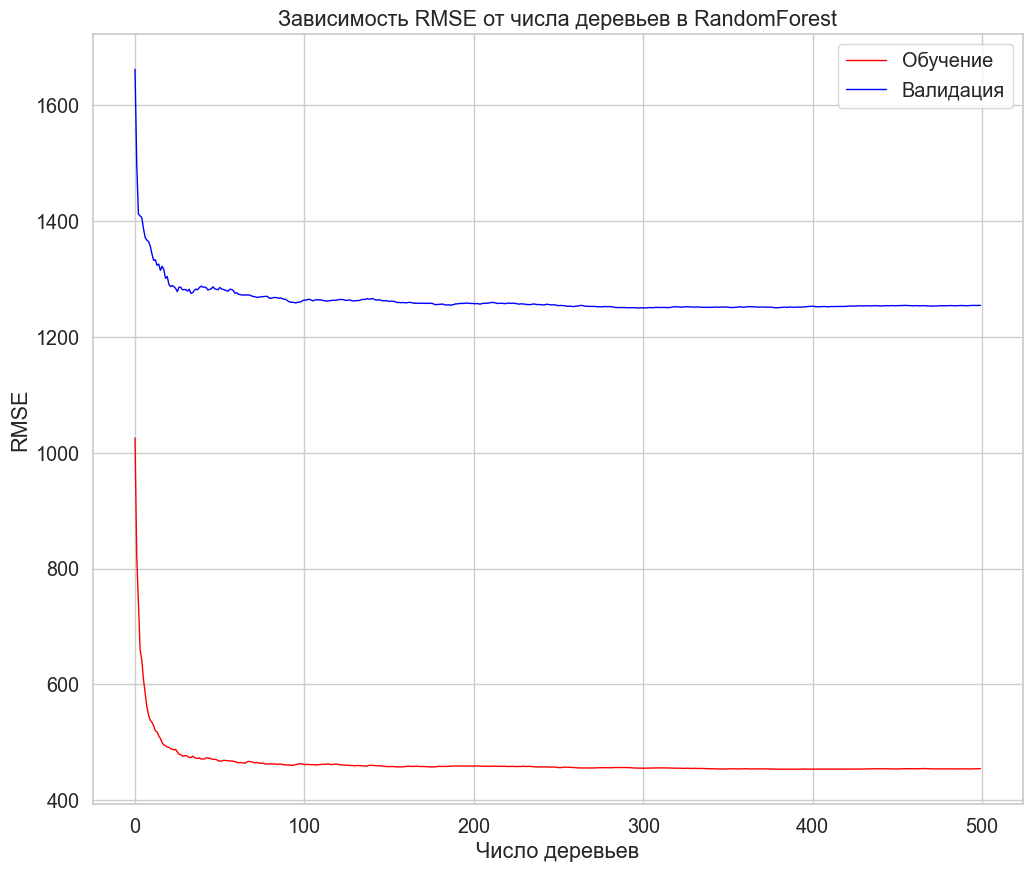

In [39]:
grid = np.arange(500)

plt.figure(figsize=(12, 10))

plt.plot(grid, rmse_train, color='red', lw=1, label='Обучение')
plt.plot(grid, rmse_valid, color='blue', lw=1, label='Валидация')

plt.title("Зависимость RMSE от числа деревьев в RandomForest")
plt.xlabel("Число деревьев")
plt.ylabel("RMSE")
plt.legend()

plt.show()

Для леса с максимальным количеством деревьев визуализируйте
важность признаков, используя поле `feature_importances_`. 

In [40]:
# Получаем значения важности признаков
importance = pd.DataFrame(forest_model.feature_importances_, index=convert_cols).T
importance

,temp,hum,windspeed,season_spring,season_summer,season_winter,mnth_2,mnth_3,mnth_4,mnth_5,...,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1,weathersit_2,weathersit_3
0,0.532707,0.158366,0.102262,0.006643,0.002584,0.071409,0.00307,0.005873,0.004061,0.003199,...,0.003422,0.005428,0.004772,0.005104,0.010092,0.005289,0.010291,0.010344,0.009812,0.006634


Убираем все признаки, важность которых равна нулю:

In [41]:
for col in importance.columns:
    series = (importance[col] == 0)
    if series[0]:
        importance.drop([col], axis=1, inplace=True)

Визуализируем:

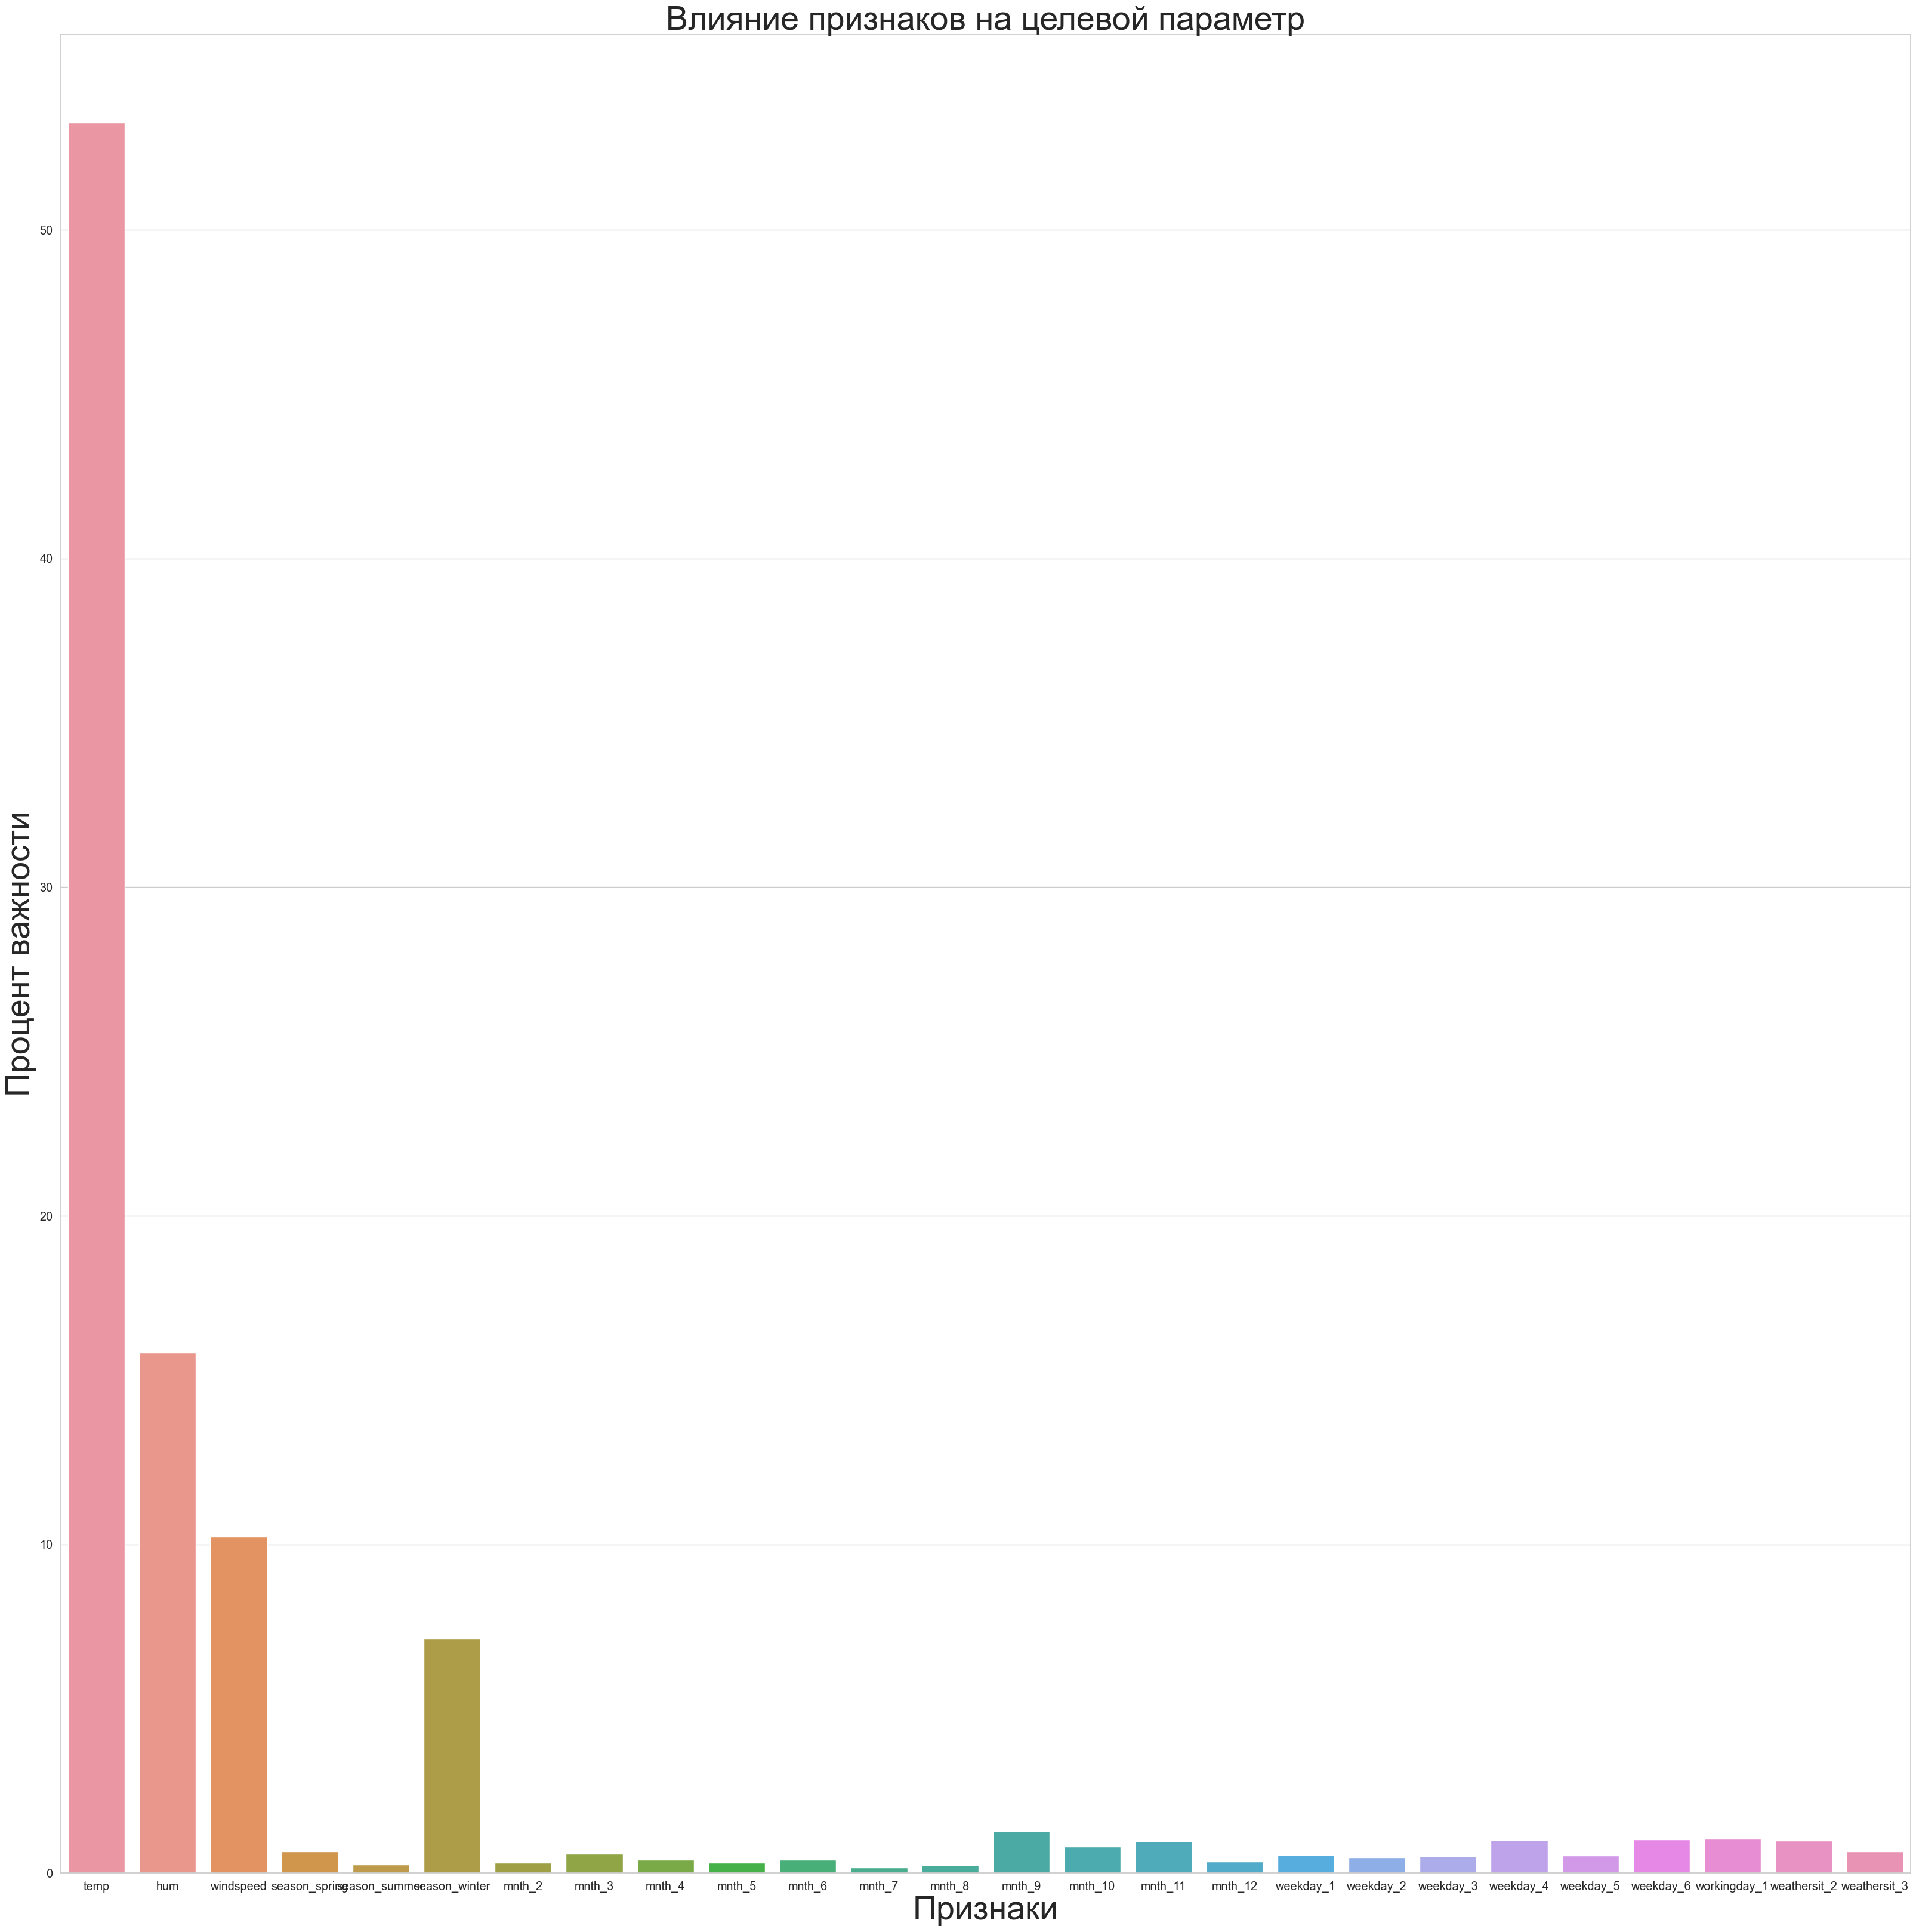

In [42]:
plt.figure(figsize=(40, 40))

sns.barplot(data=importance * 100)

plt.title("Влияние признаков на целевой параметр", size=40)
plt.xlabel("Признаки", size=40)
plt.ylabel("Процент важности", size=40)

plt.show()

Значение ошибки на тестовой выборке:

In [43]:
print ("RMSE: ", np.sqrt(mean_squared_error(test[target_feature], forest_model.predict(X_test))))

RMSE:  1187.6755194122793


Сделайте выводы.

Теперь мы рассмотрели модель случайного леса. Можно сказать, что при увеличении числа деревьев в модели ошибка предсказания плавно (аппроксимированно монотонно) уменьшается вплоть до определённого значения как на обучающей, так и на тестовой выборке. Так как деревьев в лесу много и они имеют максимальную глубину, то и признаков, имеющих важность, сильно больше. Так теперь можно удостовериться, что скорость ветра играет важную роль в выборе такого занятия, как поездка на велосипеде, а относительно высокая важность времени года "зима" может говорить о том, что зимой мало ездят на велосипеде. Температура и влажность продолжают быть лидерами. То, что workingday_1 выделяется, говорит скорее о том, явно преобладает количество рабочих дней над нерабочими. Интересно, что по месяцам сентябрь впереди. Качество случайного леса немного лучше, чем обычного дерева, но всё равно RMSE составляет около трети от среднего значения по целевому признаку.